# Image Simulation

In this tutorial, we will show how to use prysm to perform very accurate image simulation.  This combines previously shown concepts in the [Lens MTF Model](./Lens-MTF-Model.ipynb) with a few additional ones and is a more advanced tutorial.  The reader is assumed to understand basic propagation for computing PSFs.

Any image chain model or image simulation begins with defining parameters, so we'll choose some fairly arbitrary ones for our system:

Detector:
- pixel pitch: 4.5 microns
- Output resolution: 512x512
- Read Noise: 10 e-
- Full-well capacity: 50,000 e-
- Dark current: 30 e-/px/s
- bias: 800 e-
- conversion gain 5e-/DN
- Bit depth: 12-bit

Optics:
- lens F/#: 2.8
- lens EFL: 100 mm
- aperture: circular
- Optical path error? yes - sum of 2D-Q polynomials
- Fully achromatic (constant OPD over all wavelengths)

Object/Scene:
- Object: Siemens' Star
- Spectrum: Gaussian about 550 nm, 10% fractional bandwidth

From these, we begin to determine the parameters of the forward model.  The model _must_ be at least Nyquist sampled, or due to aliasing it will be invalid.  We define:

$$
Q = \frac{\lambda \text{F\#}}{pp}
$$
where $pp$ is the pixel pitch, and compute $Q = \tfrac{2.8 * .495}{4.5} = 0.306$.  495 nm is 10% below 550 nm.  Since we require $Q>=2$ in the forward model, and assume at the moment that we will use an integer level of oversampling, then the forward model is run at $Q=\text{roundup}\{2/.306\}=7x$ oversampling, or $Q=2.156$.  A notable problem is that this equation for $Q$ contains the wavelength; in other words, $Q$ is chromatic.  To get around this, we'll use matrix triple product DFTs to propagate directly to the oversampled version of the detector grid, which will be 3584x3584 samples across.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from scipy import stats

from prysm import (
    coordinates,
    convolution,
    detector,
    geometry,
    propagation,
    polynomials,
    objects,
)

from matplotlib import pyplot as plt

First, we define a bunch of parameters and set up the basic representation of the pupil:

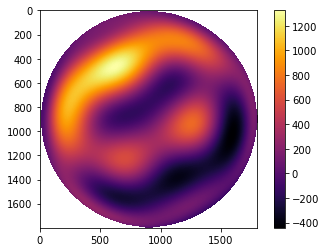

In [2]:
pp = 4.5
res = 512
fno = 2.8
efl = 100
epd = efl/fno
r_aper = epd / 2

xi, eta = coordinates.make_xy_grid(1800, diameter=epd)
r, t = coordinates.cart_to_polar(xi,eta)
dx = xi[0,1] - xi[0,0]

r_aber = r / r_aper

amp = geometry.circle(r_aper, r)

nms = [polynomials.noll_to_nm(j) for j in range(1,11)]
basis = list(polynomials.Q2d_sequence(nms, r_aber, t))

phs_coefs = np.random.rand(len(basis)) * 2000 # 200/sqrt(12) nm per mode, per uniform distribution statistics

phs = polynomials.sum_of_2d_modes(basis, phs_coefs)

# only used for plotting
mask = amp == 0
phs2 = phs.copy()
phs2[mask] = np.nan
im = plt.imshow(phs2, cmap='inferno')
plt.colorbar(im)

Note carefully the use of r_aber when computing the basis -- the polynomials are defined on $r \in [0,1]$, which necessitates this normalization.  We've used the smallest possible grid that can contain the pupil with no padding, and a large number of samples.  A requirement of the matrix triple product DFT is that the output resolution, divided by Q, must not exceed the input resolution.  If this is not honored, then Dirichlet clones of the PSF will be visible in the edge of the array, which is unphysical and incorrect.  Since we will have 3584 px on the output and Q~=2.1, we need about 1800 px on the input,

<StemContainer object of 3 artists>

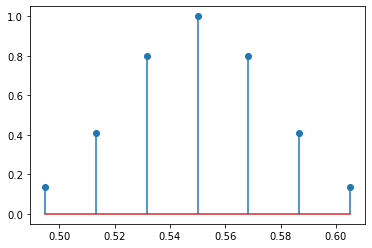

In [3]:
wvl0 = .550
halfbw = 0.1
wvls = np.linspace(wvl0*(1-halfbw), wvl0*(1+halfbw), 7)

def gauss(x, mu, sigma):
    num = (x-mu)**2
    den = 2 * sigma ** 2
    return np.exp(-num/den)

spectral_weights = gauss(wvls, .550, .550*.05)
plt.stem(wvls, spectral_weights)

Having now completed the bulk of the preparatory work, we can now compute the PSF associated with this OPD and this spectrum.  We'll propagate each wavelength to the oversampled grid:

In [4]:
psfs = []
for wvl in wvls:
    pup = propagation.Wavefront.from_amp_and_phase(amp, phs, wvl, dx)
    tmp = pup.focus_fixed_sampling(efl, pp/7, 3584)
    psfs.append(tmp.intensity.data)

# re-use this function, identical behavior
psf = polynomials.sum_of_2d_modes(psfs, spectral_weights)

# norm to sum of 1, no loss or creation of energy from convolution
psf /= psf.sum()

After producing the PSF, we need to rasterize the target.  For this, we need a new grid:

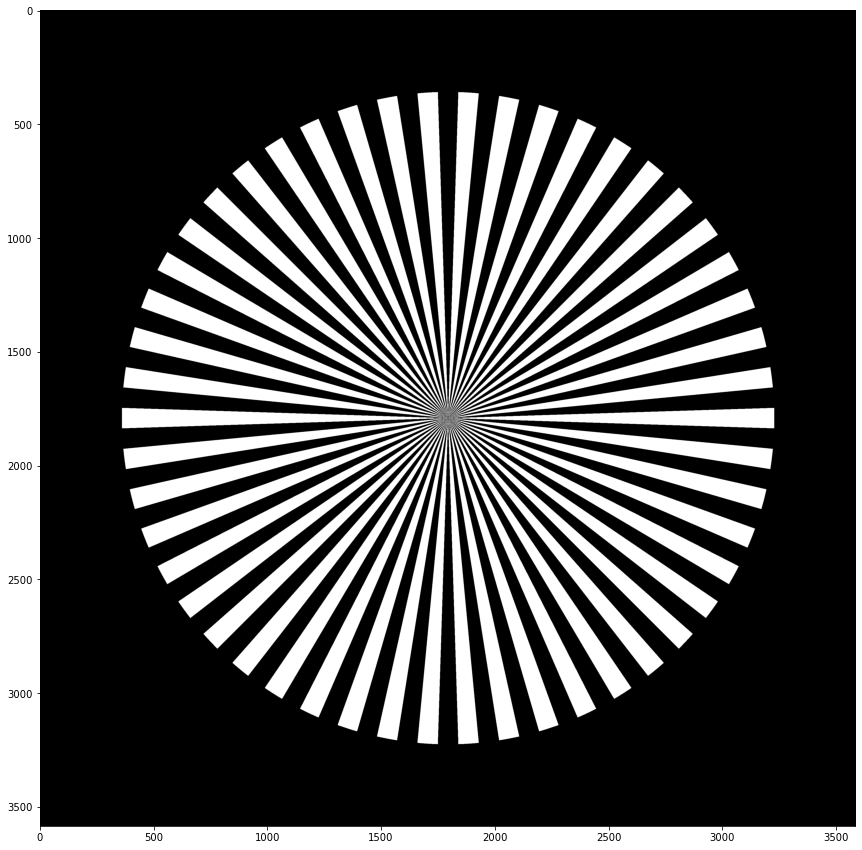

In [5]:
x, y = coordinates.make_xy_grid(tmp.data.shape, dx=tmp.dx)
r, t = coordinates.cart_to_polar(x,y)
obj = objects.siemensstar(r,t, 100, oradius=x.max()*.8)

plt.figure(figsize=(15,15))
plt.imshow(obj, cmap='gray')

Now in posession of the object and PSF, we can synthesize the aerial image, which has been blurred by the optical system:

In [6]:
img = convolution.conv(obj, psf)

The blur by the detector is modeled in this case as a 100% fill factor pixel.  Binning will bring us to the output reoslution and simultaneously:

In [7]:
img2 = detector.bindown(img, 7)

To treat noise, we build a detector model, and capture the image:

In [8]:
peak_eminus = 45_000 # heavy underexposure

In [9]:
dark_current = 10
fwc = 50_000
rn = 10
bias = 800
kgain = 5
bit_depth = 12
texp = 1/60 # 1/60 sec
cam = detector.Detector(dark_current, rn, bias, fwc, kgain, bit_depth, texp)

im = cam.expose(img2*peak_eminus)

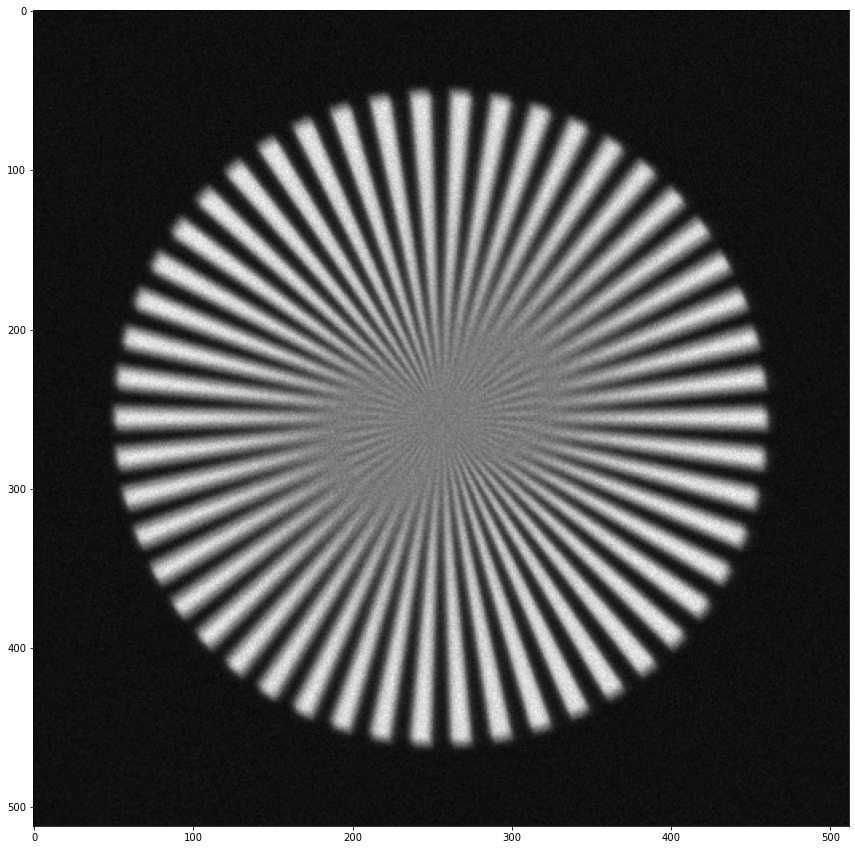

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(im, cmap='gray')

With this, we have fully modeled the image chain, including optical and electrical blurs and noise.  